Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 100)            52400     
                                                                 
 lstm_7 (LSTM)               (None, 1, 100)            80400     
                                                                 
 lstm_8 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 8)                 408       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 163417 (638.35 KB)
Trainable params: 163

19/19 [==============================] - 0s 12ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 42/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 43/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 44/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 45/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 46/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0034 - val_root_me

19/19 [==============================] - 0s 12ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0474
Epoch 89/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 90/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 91/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 92/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 93/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0062 - root_mean_squared_error: 0.0784 - val_loss: 0.0023 - val_root_me

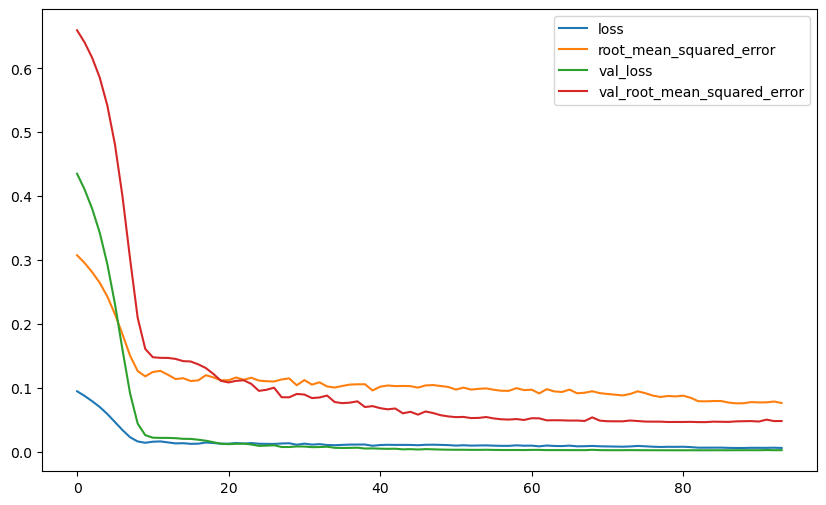

In [5]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from statsmodels.nonparametric.smoothers_lowess import lowess

#epochs
set_epochs = 100
#loess
frac_rate = 0.004

#load dataset
temp_csv_path = 'monthly_temp.csv'
df = pd.read_csv(temp_csv_path)

#time
df['Date'] = pd.to_datetime(df['Date'])
#use GCAG data
df = df[~df['Source'].str.contains('GISTEMP')]
#drop unused column
df.drop(['Source'], axis=1, inplace=True)

#LOEWSS
y = df['Mean'].dropna()
x = np.arange(0,len(y))
res = lowess(endog=y,exog=x,frac=frac_rate,it=3)
df['lowess_temp'] = res[:,1]
df.drop(['Mean'], axis=1, inplace=True)

#sort inverting
df = df[::-1]
#reset index
df = df.reset_index(drop=True)

data = df['lowess_temp'].values
data = data.reshape((-1,1))

# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

# Split into training/test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size,], data[train_size:,]

# Prepare the data in a format required for LSTM (samples, timesteps, features)
def Create_Dataset(df, lookback=1):
    X, Y = [], []
    for i in range(len(df) - lookback - 1):
        X.append(df[i:(i+lookback), 0])
        Y.append(df[i + lookback,0])
    return np.array(X), np.array(Y)

lookback = 30
X_train, Y_train = Create_Dataset(train, lookback)
X_test, Y_test   = Create_Dataset(test, lookback)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 
                   
#Use Sequential
model1 = Sequential()
#layer structure
model1.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))     
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(50))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation = 'linear'))
#show layers
model1.summary()
#early stop
early_stop = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 2)
#learn
model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.0001), 
               metrics = RootMeanSquaredError())

history = model1.fit(X_train, Y_train, 
                    epochs=set_epochs, 
                    batch_size=70,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1,
                    shuffle=False)

#show history
losses_df1 = pd.DataFrame(model1.history.history)
losses_df1.plot(figsize = (10,6))

# save model
model1.save('LSTM_Models/lstm_univariate.keras')
# load model
model1 = load_model('LSTM_Models/lstm_univariate.keras')

10/10 [==============================] - 0s 3ms/step


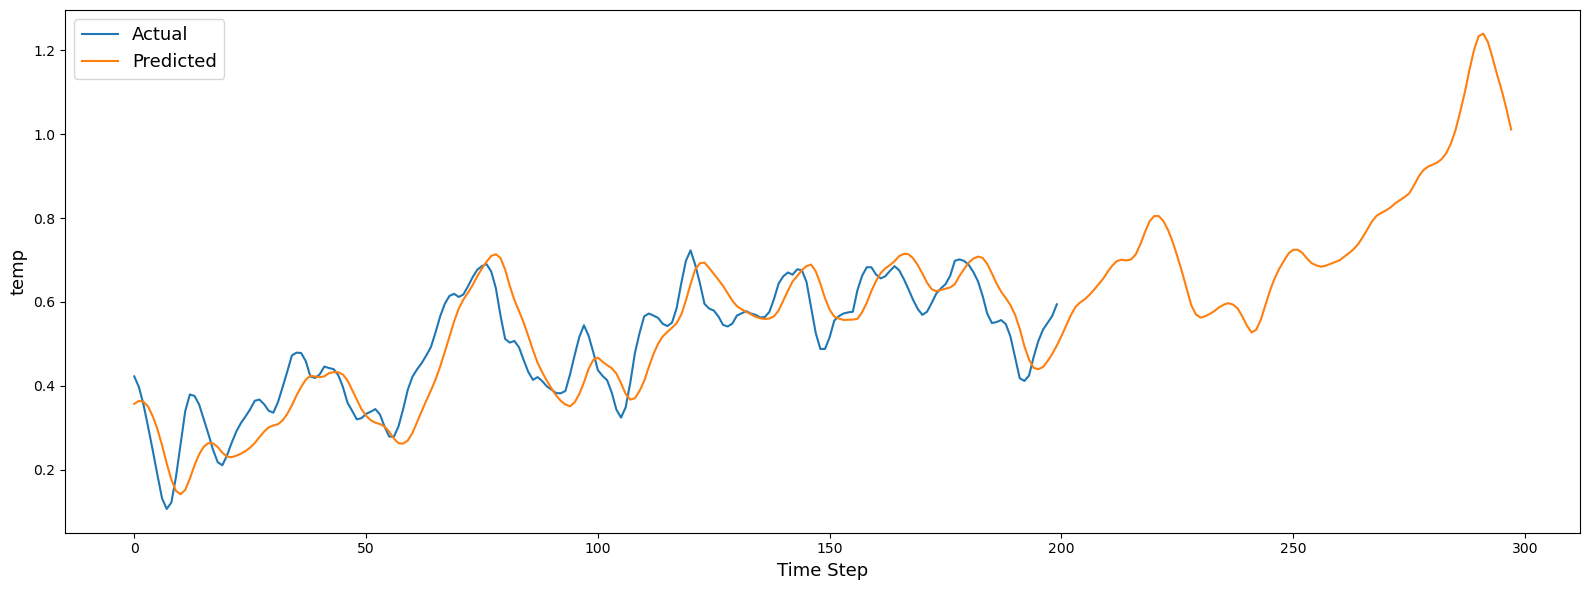

In [6]:
# Make the predictions
train_predict = model1.predict(X_train)
test_predict  = model1.predict(X_test)

# Invert the predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict  = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

actual = Y_test[0][:200]
predicted = test_predict[:,0][:300]

plt.figure(figsize=(16,6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.ylabel('temp', size=13)
plt.xlabel('Time Step', size=13)
plt.tight_layout()
plt.legend(fontsize=13)
plt.show()